In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import sys; sys.path.insert(0, '../') 
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
from invert.evaluate import eval_mean_localization_error

pp = dict(surface='inflated', hemi='both', verbose=0, cortex='low_contrast')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import mne
import pickle as pkl

fwd = mne.read_forward_solution("Clean_coarse-fwd.fif")
fwd = mne.convert_forward_solution(fwd, force_fixed=True)

with open("info.pkl", "rb") as f:
    info = pkl.load(f)

pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]
adjacency = mne.spatial_src_adjacency(fwd["src"], verbose=0)
distance_matrix = cdist(pos, pos)
fwd

Reading forward solution from c:\Users\lukas\OneDrive\Dokumente\projects\invert\dev\Clean_coarse-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (20484 sources, 59 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


Good channels,59 EEG
Bad channels,None
Source space,Surface with 20484 vertices
Source orientation,Fixed


# Simulate

In [90]:
from invert.simulate import generator
sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=2,
    n_orders=(0, 0),
    snr_range=(1, 1),
    amplitude_range=(1, 1),
    n_timecourses=200,
    n_timepoints=50,
    scale_data=False,
    add_forward_error=False,
    forward_error=0.1,
    inter_source_correlation=0.5,
    return_info=True,
    diffusion_parameter=0.1,
    beta_range = (1, 1),  # Determines the frequency spectrum of each simulted time course (1/f**beta)
    # correlation_mode="cholesky",
    # noise_color_coeff=0.5,
    normalize_leadfield=False,
    
    random_seed=None)

gen = generator(fwd, **sim_params)

C:\Users\lukas\AppData\Local\Temp\ipykernel_12168\4061301244.py:10: RuntimeWarning: All data were zero
  brain = stc.plot(**pp)


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


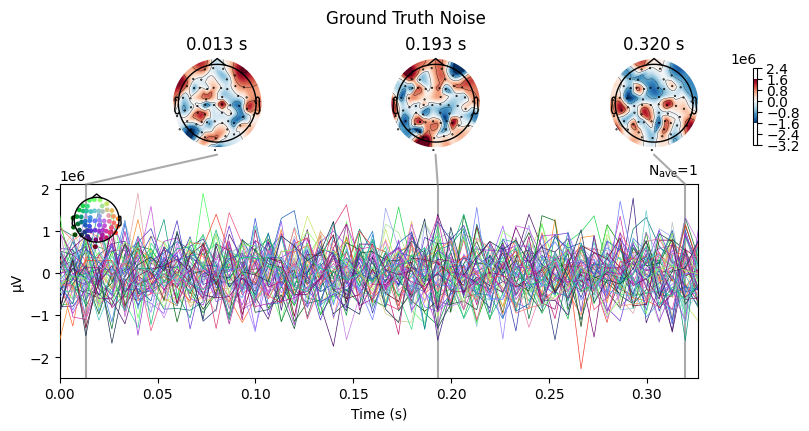

In [91]:
x, y, sim_info = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

evoked_clean = mne.EvokedArray(leadfield @ y[0].T, info, tmin=tmin)
evoked_clean.plot_joint(title="Ground Truth Noiseless")

evoked_noise = evoked.copy()
evoked_noise.data -= evoked_clean.data
evoked_noise.plot_joint(title="Ground Truth Noise")

# Solve

In [94]:
from invert import Solver
prep_leadfield = False
fwd_ = fwd.copy()
fwd_["sol"]["data"] -= fwd_["sol"]["data"].mean(axis=0)
prep_leadfield = True
evoked.set_eeg_reference(verbose=0).apply_proj()
solver = Solver("SSM", prep_leadfield=prep_leadfield)
solver.make_inverse_operator(fwd_, evoked, 
                                alpha="auto", n=2, k=2, 
                                n_orders=0, max_iter=6, 
                                lambda_reg1=(n_chans*0.001)/306,
                                lambda_reg2=(n_chans*0.0001)/306,)

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), 
                            adjacency.toarray(), distance_matrix, mode="match")
print("Adjusted", mle)

solver = Solver("SSM", prep_leadfield=prep_leadfield)
solver.make_inverse_operator(fwd_, evoked, 
                                alpha="auto", n=2, k=2, 
                                n_orders=0, max_iter=6, 
                                lambda_reg1=0.001,
                                lambda_reg2=0.0001,)

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), 
                            adjacency.toarray(), distance_matrix, mode="match")
print("Standard", mle)

No projector specified for this dataset. Please consider the method self.add_proj.
Adjusted 22.782177047807263
Standard 6.456663015786766


# SSM with and without

In [100]:
sim_params

{'use_cov': False,
 'return_mask': False,
 'batch_repetitions': 1,
 'batch_size': 1,
 'n_sources': 2,
 'n_orders': (0, 0),
 'snr_range': (1, 1),
 'amplitude_range': (1, 1),
 'n_timecourses': 200,
 'n_timepoints': 50,
 'scale_data': False,
 'add_forward_error': False,
 'forward_error': 0.1,
 'inter_source_correlation': 0.5,
 'return_info': True,
 'diffusion_parameter': 0.1,
 'beta_range': (1, 1),
 'normalize_leadfield': False,
 'random_seed': None}

In [107]:
param

{'lambda_reg1': 0.001, 'lambda_reg2': 0.0001}

In [117]:
from invert import Solver
from tqdm.notebook import tqdm
from copy import deepcopy

errors = []

n_samples = 20
tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
sim_params["random_seed"] = None
sim_params["normalize_leadfield"] = False
sim_params["inter_source_correlation"] = 0.9

params = {
    "standard": dict(lambda_reg1=0.001, lambda_reg2=0.0001),
    "adjusted": dict(lambda_reg1=(0.001*n_chans)/306, lambda_reg2=(0.0001*n_chans)/306)
}
param_kind, param = "standard", params["standard"]
solver_names = ["SSM", "AP"]
# solver_names = ["SSM",]

for i_sample in tqdm(range(n_samples)):
    gen = generator(fwd, **sim_params)
    x, y, sim_info = gen.__next__()
    print(f"Sample {i_sample}/{n_samples}")
    for solver_name in solver_names:
        print(f"\t{solver_name}")
        for car_leadfield in (True, False):
            fwd_ = deepcopy(fwd)
            if car_leadfield:
                fwd_["sol"]["data"] -= fwd_["sol"]["data"].mean(axis=0)
            evoked = mne.EvokedArray(x[0].T, info, tmin=tmin, verbose=0).set_eeg_reference(verbose=0).apply_proj(verbose=0)
            stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                                    subject=subject, verbose=0)

            solver = Solver(solver_name, prep_leadfield=False)
            solver.make_inverse_operator(fwd_, evoked, alpha="auto", n=2, k=2, n_orders=0, max_iter=6, **param)
            
            stc_ = solver.apply_inverse_operator(evoked)

            stc_.data /= abs(stc_.data).max()
            
            mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), 
                                        adjacency.toarray(), distance_matrix, mode="match")
            errors.append(dict(solver=solver_name, car_leadfield=car_leadfield, i_sample=i_sample, mle=mle))

            print("\t\t\tMLE=", round(mle,1))

        # error_true = errors[-1]["mle"]
        # print(f"""\n\tError: {error_true:.1f}""")
        # error_false = errors[-2]["mle"]
        # s = "Same" if error_true == error_false else "Different"
        # print(f"""\n\tTrue: {error_true:.1f}, False: {error_false:.1f}\n ({s})""")

  0%|          | 0/20 [00:00<?, ?it/s]

UNTESTED FUNCTION
Sample 0/20
	SSM
			MLE= 59.0
			MLE= 25.9
	AP
			MLE= 2.5
			MLE= 12.1
UNTESTED FUNCTION
Sample 1/20
	SSM
			MLE= 34.3
			MLE= 40.6
	AP
			MLE= 12.6
			MLE= 41.6
UNTESTED FUNCTION
Sample 2/20
	SSM
			MLE= 63.0
			MLE= 61.0
	AP
			MLE= 42.9
			MLE= 49.4
UNTESTED FUNCTION
Sample 3/20
	SSM
			MLE= 68.4
			MLE= 73.2
	AP
			MLE= 61.6
			MLE= 18.2
UNTESTED FUNCTION
Sample 4/20
	SSM
			MLE= 18.6
			MLE= 47.0
	AP
			MLE= 24.2
			MLE= 61.3
UNTESTED FUNCTION
Sample 5/20
	SSM
			MLE= 55.0
			MLE= 26.6
	AP
			MLE= 13.9
			MLE= 27.7
UNTESTED FUNCTION
Sample 6/20
	SSM
			MLE= 62.4
			MLE= 64.5
	AP
			MLE= 15.2
			MLE= 76.0
UNTESTED FUNCTION
Sample 7/20
	SSM
			MLE= 1.0
			MLE= 15.9
	AP
			MLE= 0.0
			MLE= 3.2
UNTESTED FUNCTION
Sample 8/20
	SSM
			MLE= 11.6
			MLE= 21.7
	AP
			MLE= 9.9
			MLE= 15.2
UNTESTED FUNCTION
Sample 9/20
	SSM
			MLE= 24.3
			MLE= 57.5
	AP
			MLE= 39.8
			MLE= 47.0
UNTESTED FUNCTION
Sample 10/20
	SSM
			MLE= 0.0
			MLE= 28.4
	AP
			MLE= 12.7
			MLE= 19.9
UNTE

In [118]:
import pandas as pd
df = pd.DataFrame(errors)

# import matplotlib.pyplot as plt
# plt.figure()
# plt.scatter(
#     df[df.prep_leadfield == True]["mle"].values,
#     df[df.prep_leadfield == False]["mle"].values,
# )

In [119]:
df.head()

,solver,car_leadfield,i_sample,mle
0,SSM,True,0,58.958727
1,SSM,False,0,25.930323
2,AP,True,0,2.497605
3,AP,False,0,12.138248
4,SSM,True,1,34.292814


In [82]:
df.groupby("param_kind").describe()

i_sample                                               mle  \
              count mean       std  min   25%  50%    75%   max count   
param_kind                                                              
adjusted       80.0  9.5  5.802662  0.0  4.75  9.5  14.25  19.0  80.0   
standard       80.0  9.5  5.802662  0.0  4.75  9.5  14.25  19.0  80.0   

                                                                      \
                 mean       std  min       25%        50%        75%   
param_kind                                                             
adjusted    12.028026  8.777937  0.0  5.530668  10.282229  17.398583   
standard     8.690410  8.000913  0.0  1.774518   7.094395  12.568625   

                       
                  max  
param_kind             
adjusted    38.112189  
standard    38.193722

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.barplot(x="solver", hue="car_leadfield", y="mle", data=df, estimator=np.median)
plt.show()

In [12]:
df.groupby("solver").describe()
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure()
sns.barplot(data=df, x="normalize_leadfield", hue="solver", y="mle", estimator="mean")

<Axes: xlabel='normalize_leadfield', ylabel='mle'>

In [ ]:
df.groupby("prep_leadfield").describe()

In [ ]:
df.groupby("prep_leadfield").describe()

# RAP-NN

In [ ]:
# from invert.solvers.esinet import SolverRAPNN

# solver_rapn = SolverRAPNN()

# solver_rapn.make_inverse_operator(fwd, evoked, n_orders=(0, 0), 
#                                   batch_size=1284, batch_repetitions=5,
#                                   n_dense_units=100, n_dense_layers=1,
#                                   snr_range=(0.2, 100), n_timepoints=20, 
#                                   inter_source_correlation=(0,1),
#                                   epochs=1,
#                                   correlation_mode="cholesky",
#                                   noise_color_coeff=(0, 0.5),
#                                   n_sources=(1, 5), verbose=1)
# # solver_rapn.train_model()
solver_rapn.model.load_weights('.weights.h5', skip_mismatch=True)

In [ ]:
from invert.simulate import generator
sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=3,
    n_orders=(0, 0),
    snr_range=(5, 5),
    amplitude_range=(1, 1),
    n_timecourses=200,
    n_timepoints=20,
    scale_data=False,
    add_forward_error=False,
    forward_error=0.1,
    inter_source_correlation=0.5,
    return_info=True,
    diffusion_parameter=0.1,
    correlation_mode="cholesky",
    noise_color_coeff=0.5,
    # correlation_mode=None,
    # noise_color_coeff=0.0,
    random_seed=None)

gen = generator(fwd, **sim_params)

x, y, sim_info = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# evoked_clean = mne.EvokedArray(leadfield @ y[0].T, info, tmin=tmin)
# evoked_clean.plot_joint(title="Ground Truth Noiseless")

# evoked_noise = evoked.copy()
# evoked_noise.data -= evoked_clean.data
# evoked_noise.plot_joint(title="Ground Truth Noise")

In [ ]:
stc_ = solver_rapn.apply_inverse_operator(evoked, sim_params["n_sources"], 
                                            refine_solution=False, 
                                            alpha=1, max_iter=100)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver_rapn.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(
    fwd["sol"]["data"] @ stc_.data, info
    ).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), 
                                   adjacency.toarray(), distance_matrix, mode="match")
print(solver_rapn.name, "mle = ", mle, " mm")

In [ ]:
for name, estimate in solver_rapn.estimates.items():
    stc_.data = estimate[:, np.newaxis]
    brain = stc_.plot(**pp)
    brain.add_text(0.1, 0.9, name, 'title',
                     font_size=14)

## SSM

In [ ]:
from invert import Solver
n_sources = sim_params["n_sources"]
solver = Solver("ap")
solver.make_inverse_operator(fwd, evoked, 
                             n_orders=sim_params["n_orders"][1], 
                             refine_solution=True, n=n_sources, 
                             k=n_sources, diffusion_parameter=0.1, 
                             stop_crit=0, max_iter=6)

stc_ = solver.apply_inverse_operator(evoked)
# stc_.data /= abs(stc_.data).max()
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, solver.name, 'title',
#                font_size=14)

# evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
# evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix, mode="match")
print(solver.name, "mle = ", mle, " mm")

# Eval many

In [ ]:
from invert.simulate import generator
sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=2,
    n_orders=(0, 0),
    snr_range=(1, 1),
    amplitude_range=(1, 1),
    n_timecourses=200,
    n_timepoints=20,
    scale_data=False,
    add_forward_error=False,
    forward_error=0.1,
    inter_source_correlation=0.9,
    return_info=True,
    diffusion_parameter=0.1,
    correlation_mode="cholesky",
    noise_color_coeff=0.5,
    # correlation_mode=None,
    # noise_color_coeff=0.0,
    random_seed=None)

gen = generator(fwd, **sim_params)

solver = Solver("ap")
solver.verbose=0
solver_rapn.verbose=0
results = []
for i_samp in range(100):
    print(i_samp)
    x, y, sim_info = gen.__next__()
    evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
    stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep,
                                subject=subject, verbose=0)

    stc_ = solver_rapn.apply_inverse_operator(evoked, sim_params["n_sources"], 
        refine_solution=True, 
        alpha=1, max_iter=10)
    

    mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix, mode="match")
    results.append(dict(solver="CovCNN", mle=mle))

    solver.make_inverse_operator(fwd, evoked, 
                             n_orders=sim_params["n_orders"][1], 
                             refine_solution=False, n=n_sources, 
                             k=n_sources, diffusion_parameter=0.1, 
                             stop_crit=0, max_iter=6)

    stc_ = solver.apply_inverse_operator(evoked)

    mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix, mode="match")
    results.append(dict(solver="AP", mle=mle))


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
plt.figure()
# sns.boxplot(data=df, x="method", y="MLE")
sns.barplot(data=df, x="solver", y="mle", estimator=np.mean)
title = f"""sources: {sim_params["n_sources"]}, snr: {sim_params["snr_range"][0]}, isc: {sim_params["inter_source_correlation"]}"""
plt.title(title)
plt.ylim(0, 40)

df.groupby("solver").describe()["mle"]

## CovCNN

In [ ]:
from invert.solvers.esinet import SolverCovCNN, SolverCovLSTM2

from copy import deepcopy

train_params = deepcopy(sim_params)
train_params["batch_repetitions"] = 10
train_params["batch_size"] = 1284
train_params["n_filters"] = 128
train_params["n_lstm_units"] = 32
train_params["n_dense_units"] = 300
train_params["epochs"] = 50
train_params["n_orders"] = (0, 1)
train_params["snr_range"] = [0.1, 10]
train_params["n_sources"] = (1, 5)
train_params["inter_source_correlation"] = (0, 1)
train_params["output_activation"] = "sigmoid"
train_params["loss"] = "cosine_similarity"
train_params["verbose"] = 1


# solver_covlstm = SolverCovLSTM2()
# solver_covlstm.make_inverse_operator(fwd, evoked, **train_params)
## solver_covlstm.train_model()

# print()
# print()

# solver_covcnn = SolverCovCNN()
# solver_covcnn.make_inverse_operator(fwd, evoked, **train_params)
solver_covcnn.train_model()

In [ ]:
from invert.evaluate import emd as get_emd

stc_ = solver_covcnn.apply_inverse_operator(evoked)
evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)

# stc_.data /= abs(stc_.data).max()
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, solver_covcnn.name, 'title',
#                font_size=14)

stc_.data = solver_covcnn.gammas[:, np.newaxis]
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, "Gamma", 'title',
               font_size=14)

evoked_.plot_joint()

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix, mode="match")
emd = get_emd(pos, stc.data[:, 0], pos, stc_.data[:, 0])
print(solver_covcnn.name, "mle = ", mle, " mm", "emd = ", emd, " mm")


# stc_ = solver_covlstm.apply_inverse_operator(evoked)
# evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)

# # stc_.data /= abs(stc_.data).max()
# # brain = stc_.plot(**pp)
# # brain.add_text(0.1, 0.9, solver_covlstm.name, 'title',
# #                font_size=14)

# stc_.data = solver_covlstm.gammas[:, np.newaxis]
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, "Gamma", 'title',
#                font_size=14)

# evoked_.plot_joint()

# mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix, mode="match")
# emd = get_emd(pos, stc.data[:, 0], pos, stc_.data[:, 0])
# print(solver_covcnn.name, "mle = ", mle, " mm", "emd = ", emd, " mm")


In [ ]:
evoked.data.shape

## LCMV

In [ ]:
from invert import Solver
solver = Solver("dSPM", prep_leadfield=False, n_reg_params=125)
solver.make_inverse_operator(fwd, evoked)

stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

In [ ]:
from invert import Solver
solver = Solver("dSPM", prep_leadfield=True)
solver.make_inverse_operator(fwd, evoked)

stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

# S-FLEX

In [ ]:
import numpy as np
from scipy.optimize import minimize

import numpy as np

def nip_translf(L):
    """
    Transforms a Leadfield matrix into a tensor or vice versa.
    Each slice of the tensor corresponds to the lead field matrix in one direction (x, y, or z).
    """
    if L.ndim == 3:
        # From tensor to matrix
        Ltrans = np.reshape(np.transpose(L, (0, 2, 1)), (L.shape[0], L.shape[1] * 3))
    elif L.ndim == 2:
        # From matrix to tensor
        if L.shape[1] % 3 != 0:
            raise ValueError("The second dimension of L must be divisible by 3")
        Ltrans = np.zeros((L.shape[0], L.shape[1] // 3, 3))
        for i in range(3):
            Ltrans[:, :, i] = L[:, np.arange(i, L.shape[1], 3)]
    else:
        raise ValueError("L should have at least 2 dimensions")
    return Ltrans


def nip_sflex(y, L, basis, maxiter=50, resnorm=0.5, regpar=1e-2, optimres=False, Winv=None):
    Nc, Nt = y.shape
    Nd, _ = L.shape
    L = nip_translf(L)
    nbasis = basis.shape[1]
    NDUM = 3

    xx0f = np.zeros((3 * Nt, nbasis)).flatten()  # Flatten the initial guess for optimization

    def objective(xx):
        # Example objective function; replace with your actual function
        return np.sum((xx - xx0f)**2)  # Placeholder

    def constraint(xx):
        # Example constraint; replace with your actual constraint
        return np.linalg.norm(xx) - 1  # Placeholder

    cons = [{'type': 'eq', 'fun': constraint}]

    options = {'maxiter': 1000, 'disp': True}
    result = minimize(objective, xx0f, method='L-BFGS-B', options=options, constraints=cons)
    xx = result.x

    # Reshape xx back to the original shape if needed
    xx = xx.reshape((3 * Nt, nbasis))  # Adjust the shape based on your specific needs

    # Process xx as needed to compute J_rec and other outputs

    return xx, result


def xforth(x):
    Q = x.shape[1]
    in1, _ = np.nonzero(x)
    in2 = np.unique(np.ceil(in1 / (Nt)).astype(int))
    l = len(in2) // NDUM
    if l == 0:
        xfo = np.zeros((Nc * Nt, Q))
    else:
        xfo = (L[:, in2] @ x[in1, :].reshape(NDUM, Nt, l, Q).transpose(0, 2, 1, 3).reshape(NDUM * l, Nt * Q)).reshape(Nc * Nt, Q)
    return xfo

def xback(x):
    return (L.T @ x.reshape(Nc, Nt)).reshape(NDUM, nbasis, Nt).transpose(0, 2, 1).ravel()

# Example usage:
# Define y, L, and basis matrices with appropriate dimensions and values.
# y = np.random.randn(Nc, Nt)
# L = np.random.randn(Nc, Nd)
# basis = np.random.randn(Nd, nbasis)
# J_rec, extras = nip_sflex(y, L, basis)
L = fwd["sol"]["data"]
y = evoked.data
basis = np.eye(n_dipoles)
J_rec, extras = nip_sflex(y[:, 0][:, np.newaxis], L, basis)

## FC

In [ ]:
from invert import Solver
from copy import deepcopy

solver = Solver("FC")
# solver.make_inverse_operator(fwd, evoked, n_sources=2, n_orders=(0,1),snr_range=(0.2,0.2))
sim_params_train = deepcopy(sim_params)
sim_params_train["batch_repetitions"] = 5
sim_params_train["batch_size"] = 1284
sim_params_train["epochs"] = 1
solver.make_inverse_operator(fwd, evoked, **sim_params_train)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

In [ ]:
solver.save("../models")

## FLAP

In [ ]:
from invert.solvers.music import SolverGeneralizedIterative

solver = SolverGeneralizedIterative()
solver = Solver("AP")
solver.make_inverse_operator(fwd, evoked, 
                             inverse_type="AP", n_orders=0, 
                             refine_solution=True, n=sim_params["n_sources"], 
                             d=sim_params["n_sources"], diffusion_parameter="auto", 
                             lambda_reg3=0.001)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

In [ ]:
from invert.solvers.empirical_bayes import SolverNLChampagne
alpha = "auto"
solver = SolverNLChampagne()
solver.make_inverse_operator(fwd, evoked, alpha=alpha)
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

In [ ]:
from invert import Solver
alpha = "auto"
solver = Solver("convexity champagne", n_reg_params=20)
solver.make_inverse_operator(fwd, evoked, alpha=alpha)
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

In [ ]:
from invert import Solver
alpha = 0.1
solver = Solver("Gamma-MAP")
solver.make_inverse_operator(fwd, evoked, alpha=alpha)
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

# Other

In [12]:
# from invert import Solver
# solver = Solver("SSM")
# solver.make_inverse_operator(fwd, evoked, n=2, k=2, max_iter=6)

# stc_ = solver.apply_inverse_operator(evoked)

# stc_.data /= abs(stc_.data).max()
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, solver.name, 'title',
#                font_size=14)

# evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
# evoked_.plot_joint()

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), 
                                        adjacency.toarray(), distance_matrix, mode="match")
print(f"Mean Localization Error: {mle:.1f} mm")

Mean Localization Error: 16.9 mm


In [ ]:
from invert.ensemble import Ensemble
solver_list = ["wMNE", "sLORETA", "LAURA", "Convexity Champagne", "GAMMA-MAP", "HOCMCMV", "SSMP", "FLEX-MUSIC"]

solver = Ensemble(solver_list, summary_type="mean")
solver.make_inverse_operator(fwd, evoked)

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

In [ ]:
from invert.solvers import SolverFLEXMUSIC_2
solver = SolverFLEXMUSIC_2()
solver.make_inverse_operator(fwd, evoked, alpha="auto")

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "MNE", "wMNE", "dSPM", "FISTA", "L1L2",
                "LORETA", "sLORETA", "eLORETA", 
                "LAURA", "Backus-Gilbert", 
                "S-MAP",
                "Champagne", "Multiple Sparse Priors", "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", "Bayesian Beamformer LORETA",
                "BCS", "Gamma-MAP", "Source-MAP", "Gamma-MAP-MSP", "Source-MAP-MSP",
                "MVAB", "LCMV", "SMV", "WNMV", "HOCMV", "ESMV", "MCMV", "ESMCMV", "ReciPSIICOS", "SAM",
                # "Fully-Connected", 
                # "LUCAS",
                # "OMP", "COSAMP", "SOMP", "REMBO", "SP", "SSP",
                # "SMP", "SSMP", "SubSMP",
                "EPIFOCUS",
                "MUSIC", "RAP-MUSIC", "TRAP-MUSIC", "JAZZ-MUSIC",
            ]
redo_solvers = np.array(["Champagne", "Multiple Sparse Priors", 
            "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", 
            "Bayesian Beamformer LORETA", "Gamma-MAP", "Source-MAP"])

all_solvers = ["TRAP-MUSIC", "JAZZ-MUSIC", "LCMV", "sLORETA"]

settings = dict(
    number_of_sources=(1, 10), 
    extents=(1, 25), 
    duration_of_trial=1, 
    target_snr=(1, 100))
alpha = "auto"

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}
errors_nmse = {sname: [] for sname in all_solvers}

solvers = dict()
sim = Simulation(fwd, info, settings).simulate(100)
    
for i in range(sim.n_samples):
    print(i)
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers :
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or solver_name in redo_solvers:
            if solver_name == "Fully-Connected":
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha, settings=dict(duration_of_trial=0., target_snr=settings["target_snr"], extents=settings["extents"]), n_simulations=5000)
            else:
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
            error_corr = np.mean(corr(stc.data, stc_hat.data))

            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat.data))

        except:
            print("\t...didnt work this time")
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        errors_nmse[solver_name].append( error_nmse )


    print("Saving errors")
    fn = "errors.pkl"
    with open(fn, 'wb') as f:
        pkl.dump([errors_corr, errors_mle, errors_auc, errors_nmse, sim.simulation_info], f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors_corr, errors_mle, errors_auc = pkl.load(f)

In [ ]:
# for key, val in errors_mle.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_corr.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_auc.items():
#     errors_mle[key] = val[:31]
    

# Plot

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)
errors = [errors_corr, errors_mle, errors_auc, errors_nmse]
error_names = ["errors_corr", "errors_mle", "errors_auc", "errors_nmse"]
for error, error_name in zip(errors, error_names):
    df = pd.DataFrame(error)


    sorted_index = df.median().sort_values().index
    df = df[sorted_index]

    plt.figure()
    sns.boxplot(data=df)
    plt.title(error_name)


# df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
# df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
# df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
# df_mean_var["Method"] = df_mean_var.index
# df_mean_var = df_mean_var.sort_values(by="Median")
# display(df_mean_var)

# plt.figure()
# sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
# plt.xlabel("Median")
# plt.ylabel("Variance")


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)